In [5]:
import torch
import torch.distributions as D
import einops
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

In [31]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Charter"
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = (
    r"\usepackage[bitstream-charter]{mathdesign} \usepackage{amsmath} \usepackage{siunitx}"
)
colors = ["black", "#0343DE", "#A52A2A", "darkorange"]
FONTSIZE = 18
FONTSIZE_LEGEND = FONTSIZE
FONTSIZE_TICK = FONTSIZE
TICKLABELSIZE = 10

In [32]:
class GammaMixture(D.MixtureSameFamily):
    def __init__(self, params):
        if len(params.shape) == 2:
            params = einops.rearrange(
                params, "... (n_mix n_params) -> ... n_mix n_params", n_params=3
            )
        self.params = params
        mix = D.Categorical(params[..., 2])
        gammas = D.Gamma(params[..., 0], params[..., 1])
        super().__init__(mix, gammas)

    def sample(self, *args, **kwargs):
        samples = super().sample(*args, **kwargs)
        return torch.round(samples)


class CategoricalDistribution(D.Categorical):
    def __init__(self, logits):
        #logits = logits/logits.sum(-1, keepdim=True)
        super().__init__(logits=logits)
        self.params = logits


class GaussianMixture(D.MixtureSameFamily):
    def __init__(self, params):
        if len(params.shape) == 2:
            params = einops.rearrange(
                params, "... (n_mix n_params) -> ... n_mix n_params", n_params=3
            )
        self.params = params
        mix = D.Categorical(params[..., 2])
        gammas = D.Normal(params[..., 0], params[..., 1])
        super().__init__(mix, gammas)

    def sample(self, *args, **kwargs):
        samples = super().sample(*args, **kwargs)
        return torch.round(samples)


In [45]:
def plot_distributions(
    file, params_list, samples, xrange, distribution_labels, diff, diff_min
):

    with PdfPages(file) as pdf:
        fig, ax = plt.subplots(figsize=(6, 4))
        for params, distribution_label in zip(params_list, distribution_labels):
            if distribution_label == "GammaMixture":
                distribution = GammaMixture
                label = r"$5 \Gamma$ Mixture"
            elif distribution_label == "GaussianMixture":
                distribution = GaussianMixture
                label = r"$5 \mathcal{N}$ Mixture"
            elif distribution_label == "Categorical":
                distribution = CategoricalDistribution
                label = "Categorical"
            
            if distribution == CategoricalDistribution:
                bins = np.arange(xrange[0], xrange[1] + 1)
                if diff:
                    ax.step(
                        bins,
                        params[bins - diff_min] / params.sum(),
                        label=label,
                    )
                else:
                    ax.step(
                        bins,
                        params[bins] / params.sum(),
                        label=label,
                    )
            else:
                x = torch.linspace(xrange[0], xrange[1], 1000).reshape(-1, 1)
                dist = distribution(params.unsqueeze(0))
                density = dist.log_prob(x).exp().detach().numpy()
                ax.plot(x, density, label=label)
        if diff:
            ax.axvline(
                samples[1] - samples[2],
                c=colors[1],
                label="Truth",
                linestyle="dashed",
            )
        else:
            ax.axvline(
                samples[1],
                c=colors[1],
                label="Particle-level\nmultiplicity",
                linestyle="dashed",
            )
            ax.axvline(
                samples[2],
                c=colors[2],
                label="Detector-level\nmultiplicity",
                linestyle="dashed",
            )
        ax.legend(loc="upper right", frameon=False, fontsize=FONTSIZE_LEGEND)
        ax.set_xlabel("Multiplicity", fontsize=FONTSIZE)
        ax.set_ylabel("Probability", fontsize=FONTSIZE)
        ax.set_ylim((0, 0.15))
        pdf.savefig(fig, bbox_inches="tight")

In [46]:
params_5gau = torch.load('tensors/params_5gau.pt')
params_5gam = torch.load('tensors/params_5gam.pt')
params_cat = torch.load('tensors/params_cat.pt')
samples = torch.load('tensors/samples_5gau.pt')

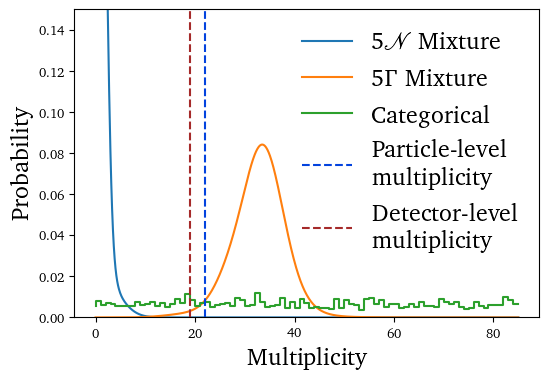

In [47]:
plot_distributions(
    'plots/merge.pdf',
    [params_5gau, params_5gam, params_cat],
    samples,
    [0,85],
    ['GaussianMixture','GammaMixture','Categorical'],
    diff=False,
    diff_min=-53
)

In [50]:
params_5gau[:,2] = params_5gau[:,2]/params_5gau[:,2].sum()

In [54]:
params_5gauD = torch.load('tensors/params_5gauD.pt')
params_catD = torch.load('tensors/params_catD.pt')
samples = torch.load('tensors/samples_5gauD.pt')

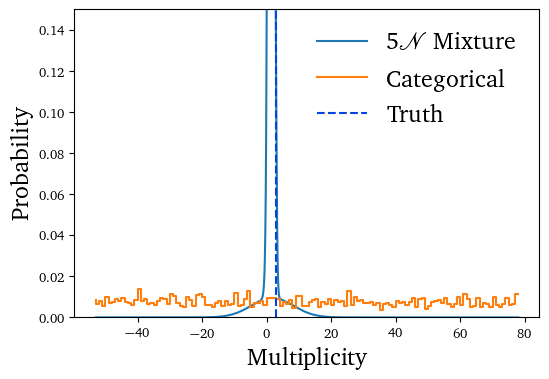

In [56]:
plot_distributions(
    'plots/mergeD.pdf',
    [params_5gauD, params_catD],
    samples,
    [-53,78],
    ['GaussianMixture','Categorical'],
    diff=True,
    diff_min=-53
)